# Tavily Summary Assignment

## 1) Process the Data

In [136]:
import json

import pandas as pd

In [137]:
# Read the JSON file
with open('summaries_1k.json', 'r') as file:
    data = json.load(file)

data = data['data']

In [138]:
# Example of the data
data[0]

{'url': 'https://www.microsoft.com/wdsi/definitions',
 'markdown_content': 'Latest security intelligence updates for Microsoft Defender Antivirus and other Microsoft antimalware - Microsoft Security Intelligence\n\n===============\n[Skip to main content](javascript:void(0))\n\n![Image 1](https://www.microsoft.com/wdsi/definitions)\n\n[Skip to main content](javascript:void(0))\n\n[![Image 2](https://uhf.microsoft.com/images/microsoft/RE1Mu3b.png)Microsoft](https://www.microsoft.com/)\n\nMicrosoft Security Intelligence\n\n[Microsoft Security Intelligence](https://www.microsoft.com/en-us/wdsi)\n\n Microsoft Security Intelligence \n\n*   [Home](https://www.microsoft.com/en-us/wdsi)\n*   [Threats](https://www.microsoft.com/en-us/wdsi/threats)\n*   [Blogs](https://cloudblogs.microsoft.com/microsoftsecure/?product=windows,windows-defender-advanced-threat-protection)\n*   \nDownloads\n    *   Updates Updates\n        *   [Antimalware updates](https://www.microsoft.com/en-us/wdsi/definitions)\n

In [139]:
# Create a dataframe from the JSON file
df = pd.DataFrame(data)
df = df.rename(columns={'summary': 'baseline_summary'})

df.head()

,url,markdown_content,baseline_summary
0,https://www.microsoft.com/wdsi/definitions,Latest security intelligence updates for Micro...,Latest security intelligence updates for Micro...
1,https://learn.microsoft.com/en-us/defender-end...,Microsoft Defender Antivirus security intellig...,Microsoft Defender Antivirus security intellig...
2,https://www.reddit.com/r/SCCM/comments/1954ghr...,Reddit - The heart of the internet\n\n========...,Reddit - The heart of the internet Image 1: r/...
3,https://www.catalog.update.microsoft.com/Searc...,Microsoft Update Catalog\n\n===============\n\...,Microsoft®Update CatalogFAQ|helpImage 1Image 2...
4,https://answers.microsoft.com/en-us/windows/fo...,KB2267602 continually wanting to update - Micr...,KB2267602 continually wanting to update - Micr...


## 2) Lite Summary: LexRank Extractive Summarization

We use a **LexRank-based** extractive summarization algorithm to produce concise summaries from preprocessed text. LexRank builds a **sentence similarity graph** using TF-IDF vectors and applies **PageRank** to rank sentences by importance.

#### Pipeline
1. **Preprocessing**  
   - Remove boilerplate, links, and navigation text using `preprocess_lite.clean_web_text`.
   - Split into sentences with filtering for length and noise.

2. **Graph Construction**  
   - Compute TF-IDF vectors for each sentence.
   - Build a cosine similarity matrix.
   - Apply a similarity threshold (0.1) to sparsify the graph.

3. **Ranking (LexRank)**  
   - Normalize the graph into a row-stochastic matrix.
   - Apply PageRank to compute sentence importance scores.

4. **Sentence Selection**  
   - Select top-ranked sentences, enforcing low redundancy via Jaccard similarity filtering.
   - Respect the original document order (optional).
   - Stop when reaching the `max_chars` limit.

In [140]:
from preprocess import clean_web_text
from graph_rank_summarizer import LexRankSummarizer, LexRankConfig

In [141]:
# --- Lite Summary Example ---

from IPython.display import display, HTML

# Get the raw text
i = 0
raw_text = df.loc[i, 'markdown_content']

# Clean the raw text
clean_text = clean_web_text(raw_text)

# Summarize the cleaned text
cfg = LexRankConfig(analyzer="word", ngram_range=(3,5), threshold=0.1, max_chars=1200)
smr = LexRankSummarizer(cfg)
lex_out = smr.summarize(title=None, text=clean_text)

# Display the summary
text = raw_text[:1000].replace('\n', '<br>')
display(HTML(
    f"""
    <h2>LexRank Summary Example</h2>
    <b>URL:</b> <p>{df.loc[i, 'url']}</p>
    <b>Text Snippet:</b> <p>{text}...</p>
    <b>LexRank Summary:</b> <p>{lex_out['summary']}</p>
    """
))

In [142]:
# --- Apply Lite Summarization to All Data ---

from tqdm import tqdm
from time import perf_counter

def process_row(raw_text):
    # Start time
    start = perf_counter()

    # Clean the raw text
    clean_text = clean_web_text(raw_text)

    if len(clean_text) < 100:
        # Summarize the raw text if clean text is too short
        lex_out = smr.summarize(title=None, text=raw_text)
    else:
        # Summarize the cleaned text
        lex_out = smr.summarize(title=None, text=clean_text)

    # Stop time
    elapsed = perf_counter() - start

    return pd.Series({
        'content_length_in_words': len(raw_text.split(' ')),
        'lite_summary': lex_out['summary'],
        'length_in_characters': len(lex_out['summary']),
        'time_in_seconds': elapsed,
    })

# Apply the lite summarizer to the dataframe in one pass
tqdm.pandas()
result = df['markdown_content'].progress_apply(process_row)
lite_df = df.copy()
lite_df[['content_length_in_words', 'lite_summary', 'length_in_characters', 'time_in_seconds']] = result

lite_df.head()

100%|██████████| 1000/1000 [01:24<00:00, 11.85it/s]


,url,markdown_content,baseline_summary,content_length_in_words,lite_summary,length_in_characters,time_in_seconds
0,https://www.microsoft.com/wdsi/definitions,Latest security intelligence updates for Micro...,Latest security intelligence updates for Micro...,1701,Latest security intelligence updates for Micro...,1163,0.011308
1,https://learn.microsoft.com/en-us/defender-end...,Microsoft Defender Antivirus security intellig...,Microsoft Defender Antivirus security intellig...,4580,Microsoft Defender Vulnerability Management. M...,1193,0.051650
2,https://www.reddit.com/r/SCCM/comments/1954ghr...,Reddit - The heart of the internet\n\n========...,Reddit - The heart of the internet Image 1: r/...,589,Reddit - The heart of the internet. Skip to ma...,1178,0.014588
3,https://www.catalog.update.microsoft.com/Searc...,Microsoft Update Catalog\n\n===============\n\...,Microsoft®Update CatalogFAQ|helpImage 1Image 2...,817,Microsoft Update Catalog. Microsoft®Update Cat...,578,0.006054
4,https://answers.microsoft.com/en-us/windows/fo...,KB2267602 continually wanting to update - Micr...,KB2267602 continually wanting to update - Micr...,1197,"Skip to main content. November 17–21, 2025. Jo...",1138,0.014343


,Metric,Seconds
0,Mean,0.083 s
1,Max,10.936 s
2,Min,0.000 s


,Metric,Characters
0,Mean,"1,083"
1,Max,"1,199"
2,Min,106


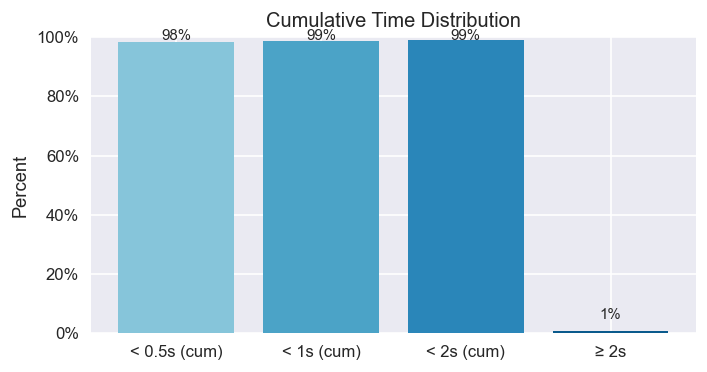

In [143]:
# --- Display stats ---

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

# Compute distributions (cumulative, matching the original metrics)
under_0_5 = (lite_df['time_in_seconds'] < 0.5).mean()
under_1 = (lite_df['time_in_seconds'] < 1).mean()
under_2 = (lite_df['time_in_seconds'] < 2).mean()
over_2 = (lite_df['time_in_seconds'] >= 2).mean()

# Aggregate stats
mean_time = lite_df['time_in_seconds'].mean()
max_time = lite_df['time_in_seconds'].max()
min_time = lite_df['time_in_seconds'].min()

mean_len = lite_df['length_in_characters'].mean()
max_len = lite_df['length_in_characters'].max()
min_len = lite_df['length_in_characters'].min()

# Styled tables
dist_df = pd.DataFrame({
    'Bucket': ['< 0.5s (cum)', '< 1s (cum)', '< 2s (cum)', '≥ 2s'],
    'Percent': [under_0_5, under_1, under_2, over_2],
})

time_df = pd.DataFrame({
    'Metric': ['Mean', 'Max', 'Min'],
    'Seconds': [mean_time, max_time, min_time],
})

len_df = pd.DataFrame({
    'Metric': ['Mean', 'Max', 'Min'],
    'Characters': [mean_len, max_len, min_len],
})

# Display header
display(HTML('<h3>Lite Summarizer Stats</h3>'))

# Style helpers (compatible with older pandas)
def styled_percent_table(df):
    return (df.style
              .set_table_styles([
                  {'selector': 'th', 'props': [('background-color', '#f6f8fa'), ('text-align', 'left')]},
                  {'selector': 'td', 'props': [('padding', '6px 12px')]}
              ])
              .format({'Percent': '{:.1%}'}))

def styled_time_table(df):
    return (df.style
              .set_table_styles([
                  {'selector': 'th', 'props': [('background-color', '#f6f8fa'), ('text-align', 'left')]},
                  {'selector': 'td', 'props': [('padding', '6px 12px')]}
              ])
              .format({'Seconds': '{:.3f} s'}))

def styled_len_table(df):
    return (df.style
              .set_table_styles([
                  {'selector': 'th', 'props': [('background-color', '#f6f8fa'), ('text-align', 'left')]},
                  {'selector': 'td', 'props': [('padding', '6px 12px')]}
              ])
              .format({'Characters': '{:,.0f}'}))

# Show tables
display(styled_time_table(time_df))
display(styled_len_table(len_df))

# Visualization: cumulative time distribution
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(6, 3.2), dpi=120)
bars = ax.bar(dist_df['Bucket'], dist_df['Percent'], color=['#86c5da', '#4ba3c7', '#2a86b9', '#0a5a8c'])
ax.set_ylim(0, 1)
ax.set_ylabel('Percent')
ax.set_title('Cumulative Time Distribution')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
for b, v in zip(bars, dist_df['Percent']):
    ax.text(b.get_x() + b.get_width()/2, min(v + 0.03, 0.98), f'{v:.0%}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

In [144]:
# Save DataFrame to pickle
lite_df.to_pickle('summaries/lite_summaries.pkl')

## 3) Balanced Summary: LexRank + Small LLM

The goal is to produce a concise, high‑quality summary with low latency. We achieve this by combining fast extractive summarization with a lightweight generative pass.

#### Pipeline
  1. **Preprocessing**

        - Clean the raw page text using `preprocess.clean_web_text` to remove boilerplate, navigation, links, and noise. 
        - If the cleaned text is too short, fall back to the raw text.
  2. **Lite (Extractive) Summarization**: 
        - Run Lite Summarization to quickly condense the document into a rich extractive summary capped at about 3,000 characters.
        - `LexRankConfig(analyzer="word", ngram_range=(3,5), threshold=0.1, max_chars=3000)`
  3. **Balanced (Generative) Summarization**: 
        - Feed the Lite summary to a small LLM (Amazon Nova Micro).
        - Rewrite into a fluent, focused summary (≤ 200 words).

#### Why this balances latency and quality
  - The extractive step drastically reduces input length while preserving coverage, keeping the generative step cheap and fast.
  - The small LLM then improves coherence, readability, and phrasing without expensive long‑context reasoning.

In [145]:
import boto3
from dotenv import load_dotenv

In [146]:
# Load Bedrock API key
_ = load_dotenv()

In [147]:
# Create the Bedrock Runtime client
client = boto3.client('bedrock-runtime', region_name='us-east-1')

In [148]:
# Use Amazon Nova Micro for summarization
model_id = "us.amazon.nova-micro-v1:0"

In [149]:
# Define system prompt and user prompt
system_prompt = """You are a helpful assistant that summarizes web pages. \
You will be given a web page text. Without using any headers or numbering, provide a summary of the text following these guidelines:
- You MUST summarize in the same language as the given text.
- The summary MUST stay within 200 words
- Provide a short but comprehensive summary, highlight the main points of the text"""

user_prompt = """<text>
{}
</text>
Remember, you must summarize in the same language as the above text."""

def get_user_prompt(text):
    """
    Get the user prompt for the given text
    """
    return user_prompt.format(text)

In [150]:
# Define a function to get a response from a model
def get_response(model_id, system_prompt, user_prompt):
    """
    Get a response from the model

    Args:
        model_id: The model ID to use for the model
        system_prompt: The system prompt to use for the model
        user_prompt: The user prompt to use for the model

    Returns:
        The response from the model
    """
    conversation = [
        {
            "role": "user",
            "content": [{"text": system_prompt}],
        },
        {
            "role": "user",
            "content": [{"text": user_prompt}],
        }
    ]

    # Get response from model
    response = client.converse(
        modelId=model_id,
        messages=conversation,
        inferenceConfig={"maxTokens": 230, "temperature": 0.1},
    )

    # Return the response
    return response["output"]["message"]["content"][0]["text"]

In [151]:
# --- Example response ---

from IPython.display import display, HTML

# Example text
example_text = df.loc[0, 'markdown_content']

# Clean text
example_text = clean_web_text(example_text)

# Initialize the LexRank summarizer with max characters set to 3000
cfg = LexRankConfig(analyzer="word", ngram_range=(3,5), threshold=0.1, max_chars=3000)
smr = LexRankSummarizer(cfg)

# Summarize the cleaned text with the Lite summarizer
lex_out = smr.summarize(title=None, text=example_text)
lite_smr = lex_out['summary']

response = get_response(model_id, system_prompt, get_user_prompt(lite_smr))

display(HTML(f"Example Text Snippet: <p>{example_text[:1000]}...</p> Summary: <p>{response}</p>"))

In [152]:
# --- Summarize the dataset ---

def process_row(raw_text):
    # Start time
    start = perf_counter()

    # Clean the raw text
    clean_text = clean_web_text(raw_text)

    if len(clean_text) < 100 and len(raw_text) < 5000:
        # Summarize the raw text if clean text is too short
        lex_out = smr.summarize(title=None, text=raw_text)
    else:
        # Summarize the cleaned text
        lex_out = smr.summarize(title=None, text=clean_text)
    
    lite_smr = lex_out['summary']
    
    # Summarize using the LLM with invoke
    balanced_smr = get_response(model_id, system_prompt, get_user_prompt(lite_smr))

    # Stop time
    elapsed = perf_counter() - start

    # Pricing (approximate tokens by words)
    input_word_count = len(lite_smr.split())
    output_word_count = len(balanced_smr.split())
    input_price = (input_word_count / 1000.0) * 0.000035
    output_price = (output_word_count / 1000.0) * 0.00014
    total_price = input_price + output_price

    return pd.Series({
        'content_length_in_words': len(raw_text.split(' ')),
        'balanced_summary': balanced_smr,
        'length_in_characters': len(balanced_smr),
        'time_in_seconds': elapsed,
        'input_price': input_price,
        'output_price': output_price,
        'total_price': total_price,
    })

# Apply the balanced summarizer to the dataframe
_tqdm = tqdm.pandas()
result = df['markdown_content'].progress_apply(process_row)
balanced_df = df.copy()
balanced_df[['content_length_in_words', 'balanced_summary', 'length_in_characters', 'time_in_seconds', 'input_price', 'output_price', 'total_price']] = result

balanced_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [26:00<00:00,  1.56s/it]


,url,markdown_content,baseline_summary,content_length_in_words,balanced_summary,length_in_characters,time_in_seconds,input_price,output_price,total_price
0,https://www.microsoft.com/wdsi/definitions,Latest security intelligence updates for Micro...,Latest security intelligence updates for Micro...,1701,The latest security intelligence updates for M...,1038,1.538900,0.000008,0.000019,0.000028
1,https://learn.microsoft.com/en-us/defender-end...,Microsoft Defender Antivirus security intellig...,Microsoft Defender Antivirus security intellig...,4580,The text provides an overview of Microsoft Def...,1029,1.430679,0.000007,0.000021,0.000028
2,https://www.reddit.com/r/SCCM/comments/1954ghr...,Reddit - The heart of the internet\n\n========...,Reddit - The heart of the internet Image 1: r/...,589,"The text primarily revolves around Reddit, des...",729,1.267316,0.000006,0.000015,0.000021
3,https://www.catalog.update.microsoft.com/Searc...,Microsoft Update Catalog\n\n===============\n\...,Microsoft®Update CatalogFAQ|helpImage 1Image 2...,817,The Microsoft Update Catalog provides a compre...,661,1.292598,0.000003,0.000014,0.000017
4,https://answers.microsoft.com/en-us/windows/fo...,KB2267602 continually wanting to update - Micr...,KB2267602 continually wanting to update - Micr...,1197,The text highlights an upcoming event from Nov...,741,1.225015,0.000009,0.000014,0.000023


In [153]:
# Save the balanced summaries to pickle
balanced_df.to_pickle('summaries/balanced_summaries.pkl')

,Metric,Input Price ($),Output Price ($),Total Price ($)
0,Mean,$0.000011,$0.000016,$0.000027
1,Max,$0.000046,$0.000026,$0.000046
2,Min,$0.000000,$0.000000,$0.000001
3,Sum,$0.010543,$0.016055,$0.026597


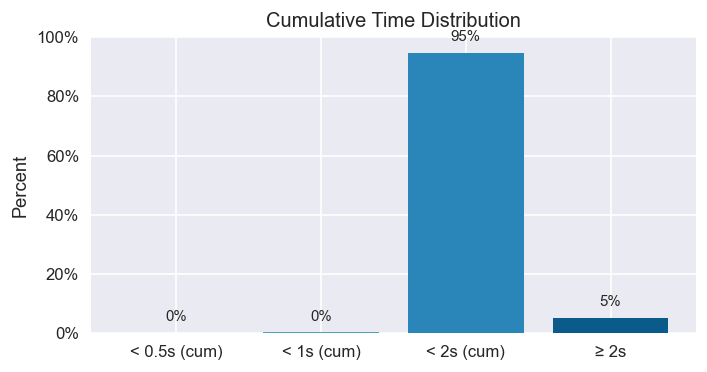

In [ ]:
# --- Display Statistics ---

import matplotlib.pyplot as plt

# Prices (mean, max, min, sum) for input, output, and total
price_stats = pd.DataFrame({
    'Metric': ['Mean', 'Max', 'Min', 'Sum'],
    'Input Price ($)': [
        balanced_df['input_price'].mean(),
        balanced_df['input_price'].max(),
        balanced_df['input_price'].min(),
        balanced_df['input_price'].sum(),
    ],
    'Output Price ($)': [
        balanced_df['output_price'].mean(),
        balanced_df['output_price'].max(),
        balanced_df['output_price'].min(),
        balanced_df['output_price'].sum(),
    ],
    'Total Price ($)': [
        balanced_df['total_price'].mean(),
        balanced_df['total_price'].max(),
        balanced_df['total_price'].min(),
        balanced_df['total_price'].sum(),
    ],
})

def style_currency_table(df: pd.DataFrame):
    return (df.style
              .set_table_styles([
                  {'selector': 'th', 'props': [('background-color', '#f6f8fa'), ('text-align', 'left')]},
                  {'selector': 'td', 'props': [('padding', '6px 12px')]}
              ])
              .format({'Input Price ($)': '${:,.6f}',
                       'Output Price ($)': '${:,.6f}',
                       'Total Price ($)': '${:,.6f}'}))

# Display price stats
display(HTML('<h3>Balanced Summaries — Price Stats</h3>'))
display(style_currency_table(price_stats))

# Latency cumulative distribution
under_0_5 = (balanced_df['time_in_seconds'] < 0.5).mean()
under_1 = (balanced_df['time_in_seconds'] < 1).mean()
under_2 = (balanced_df['time_in_seconds'] < 2).mean()
over_2 = (balanced_df['time_in_seconds'] >= 2).mean()

latency_dist_df = pd.DataFrame({
    'Bucket': ['< 0.5s (cum)', '< 1s (cum)', '< 2s (cum)', '≥ 2s'],
    'Percent': [under_0_5, under_1, under_2, over_2],
})

# Display latency header
display(HTML('<h3>Balanced Summaries — Latency (Cumulative)</h3>'))

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(6, 3.2), dpi=120)
bars = ax.bar(latency_dist_df['Bucket'], latency_dist_df['Percent'], color=['#86c5da', '#4ba3c7', '#2a86b9', '#0a5a8c'])
ax.set_ylim(0, 1)
ax.set_ylabel('Percent')
ax.set_title('Cumulative Time Distribution')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
for b, v in zip(bars, latency_dist_df['Percent']):
    ax.text(b.get_x() + b.get_width()/2, min(v + 0.03, 0.98), f'{v:.0%}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

## 4) Advanced Summary: Recursive Long-Document Summarization

This method uses a **two-stage recursive summarization process** to produce high-quality summaries while handling very long documents efficiently:

1. **Recursive Compression with Nova Lite** – progressively shortens the text while retaining key points.
2. **Final Cohesive Summary with Claude Sonnet 4** – polishes and condenses the reduced text into a clean, final summary.

#### Pipeline
1. **Preprocessing**

    - Clean the raw page text using `preprocess.clean_web_text` to remove boilerplate, navigation, links, and noise. 
    - If the cleaned text is too short, fall back to the raw text.

2. **Recursive Compression with Nova Lite**

    - The document is split into overlapping chunks.
    - Each chunk is summarized by **Amazon Nova Lite**.
    - Summaries are concatenated and iteratively re-summarized until the text fits within the desired token budget.

3. **Final Cohesive Summary with Claude Sonnet 4**

    - The reduced text from Stage 2 is passed to **Claude Sonnet 4** for a final, polished, cohesive summary.

In [ ]:
# Define an updated function to get a response from a model
def get_response(model_id, system_prompt, user_prompt, max_tokens=230):
    """
    Get a response from the model

    Args:
        model_id: The model ID to use for the model
        system_prompt: The system prompt to use for the model
        user_prompt: The user prompt to use for the model
        max_tokens: The maximum number of tokens to generate

    Returns:
        The response from the model
    """
    conversation = [
        {
            "role": "user",
            "content": [{"text": system_prompt}],
        },
        {
            "role": "user",
            "content": [{"text": user_prompt}],
        }
    ]

    # Get response from model
    response = client.converse(
        modelId=model_id,
        messages=conversation,
        inferenceConfig={"maxTokens": max_tokens, "temperature": 0.1},
    )

    # Return the response
    return response["output"]["message"]["content"][0]["text"]

In [ ]:
# --- Recursive long-doc compression with Nova Lite, then final pass with Claude Sonnet 4 ---

from typing import List, Tuple, Dict
from langchain.text_splitter import RecursiveCharacterTextSplitter

# ======= Model IDs (Bedrock) =======
NOVA_LITE = "amazon.nova-lite-v1:0"
CLAUDE_SONNET_4 = "us.anthropic.claude-sonnet-4-20250514-v1:0"

# ======= Pricing (USD per 1K tokens) =======
NOVA_IN_PER_K   = 0.00006
NOVA_OUT_PER_K  = 0.00024
SONNET_IN_PER_K = 0.003
SONNET_OUT_PER_K= 0.015

def cost_from_tokens(input_tokens: int, output_tokens: int, in_per_k: float, out_per_k: float) -> Dict:
    cost_in  = (input_tokens / 1000.0) * in_per_k
    cost_out = (output_tokens / 1000.0) * out_per_k
    return {
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "cost_input_usd": round(cost_in, 6),
        "cost_output_usd": round(cost_out, 6),
        "cost_total_usd": round(cost_in + cost_out, 6),
    }


# ======= Token/word utilities (approximate) =======
def approx_tokens(s: str) -> int:
    """
    Very rough token count for budgeting.
    ~4 characters per token is a decent rule of thumb for English text.
    """
    if not s:
        return 0
    return (len(s) + 3) // 4

def approx_words_to_tokens(words: int) -> int:
    """
    Heuristic: ~1.33 tokens per word.
    """
    return int(round(words * 1.33))

def approx_tokens_to_words(tokens: int) -> int:
    """
    Heuristic inverse of above: ~0.75 words per token.
    """
    return max(1, int(round(tokens * 0.75)))

# ======= Chunking =======
def create_text_chunks(text: str, chunk_chars: int = 4000, overlap: int = 300) -> List[str]:
    """
    Split text into overlapping chunks using LangChain's RecursiveCharacterTextSplitter.

    Args:
        text (str): The text to chunk
        chunk_chars (int): The number of characters in each chunk
        overlap (int): The number of characters to overlap between chunks

    Returns:
        chunks (List[str]): A list of chunks
    """
    if not text:
        return []
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_chars,
        chunk_overlap=overlap,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    
    chunks = text_splitter.split_text(text)
    return chunks

# ======= Prompt templates =======
NOVA_SYSTEM_PROMPT = """You are a helpful assistant that summarizes web pages. \
You will be given a web page text. Without using any headers or numbering, provide a summary of the text following these guidelines:
- You MUST summarize in the same language as the given text.
- The summary MUST stay within {} words
- Provide a short but comprehensive summary, highlight the main points of the text"""

SONNET_SYSTEM_PROMPT = """You are an expert summarizer. \
You will be given concatenated summaries of a web page. Without using any headers or numbering, provide a summary of the text following these guidelines:
- You MUST summarize in the same language as the given text.
- The summary MUST stay within 200 words
- Provide a short but comprehensive summary, highlight the main points of the text"""

USER_PROMPT = """<text>
{}
</text>
Remember, you must summarize in the same language as the above text."""

def get_user_prompt(text):
    """
    Get the user prompt for the given text
    """
    return USER_PROMPT.format(text)

# ======= Core round: summarize current text into a shorter concatenation =======
def summarize_one_round_with_small_llm(
    text: str,
    *,
    round_target_tokens: int,
    chunk_chars: int = 4000,
    overlap: int = 300,
    words_per_chunk_min: int = 80,
    words_per_chunk_max: int = 220,
    min_chunk_max_tokens: int = 60,
    max_chunk_max_tokens: int = 400,
) -> Tuple[str, Dict]:

    def clamp(v, lo, hi):
        return max(lo, min(hi, v))

    chunks = create_text_chunks(text, chunk_chars=chunk_chars, overlap=overlap)
    if not chunks:
        return "", {"chunks": 0, "words_per_chunk": 0}

    m = len(chunks)

    tokens_per_chunk_cap = clamp(round_target_tokens // m, min_chunk_max_tokens, max_chunk_max_tokens)
    words_from_tokens_cap = approx_tokens_to_words(tokens_per_chunk_cap)
    target_words_total = max(1, approx_tokens_to_words(round_target_tokens))
    words_per_chunk_from_total = max(
        words_per_chunk_min,
        min(words_per_chunk_max, target_words_total // m),
    )
    words_per_chunk = clamp(
        min(words_from_tokens_cap, words_per_chunk_from_total),
        words_per_chunk_min,
        words_per_chunk_max,
    )

    summaries = []

    # Accounting accumulators for Nova Lite
    nova_input_tokens_total = 0
    nova_output_tokens_total = 0

    for chunk in chunks:
        system_prompt = NOVA_SYSTEM_PROMPT.format(words_per_chunk)
        user_prompt = get_user_prompt(chunk)

        # Estimate input tokens for this call (system + user)
        in_tokens = approx_tokens(system_prompt) + approx_tokens(user_prompt)

        summary = get_response(
            NOVA_LITE,
            system_prompt,
            user_prompt,
            max_tokens=tokens_per_chunk_cap,
        ).strip()

        out_tokens = approx_tokens(summary)

        # Accumulate
        nova_input_tokens_total  += in_tokens
        nova_output_tokens_total += out_tokens

        summaries.append(summary)

    concatenated = "\n".join(summaries).strip()

    # Nova cost for this round
    nova_round_cost = cost_from_tokens(
        nova_input_tokens_total,
        nova_output_tokens_total,
        in_per_k=NOVA_IN_PER_K,
        out_per_k=NOVA_OUT_PER_K,
    )

    diagnostics = {
        "chunks": m,
        "words_per_chunk": words_per_chunk,
        "tokens_per_chunk_cap": tokens_per_chunk_cap,
        "round_target_tokens": round_target_tokens,
        "input_tokens_est": approx_tokens(text),
        "output_tokens_est": approx_tokens(concatenated),
        "nova_round": nova_round_cost,
    }
    return concatenated, diagnostics

# ======= Recursive reducer =======
def recursive_reduce_with_small_llm(
    text: str,
    *,
    final_budget_tokens: int,
    max_rounds: int = 4,
    compression_ratio: float = 0.6,   # 40% reduction each round (approx)
    min_reduction: float = 0.07,      # require at least 7% progress to continue
    chunk_chars: int = 4000,
    overlap: int = 300,
    words_per_chunk_min: int = 80,
    words_per_chunk_max: int = 220,
    verbose: bool = True,
) -> Tuple[str, List[Dict]]:
    """
    Repeatedly summarize with the small LLM until:
      - estimated tokens <= final_budget_tokens, or
      - max_rounds reached, or
      - progress stalls (< min_reduction improvement)
    Returns (reduced_text, history)
    """
    history: List[Dict] = []
    current = text
    prev_tokens = approx_tokens(current)

    # Cumulative Nova usage across rounds
    nova_total_input_tokens = 0
    nova_total_output_tokens = 0
    nova_total_cost_usd = 0.0

    if verbose:
        print(f"[start] tokens≈{prev_tokens:,}, target≤{final_budget_tokens:,}")

    for r in range(1, max_rounds + 1):
        if prev_tokens <= final_budget_tokens:
            if verbose:
                print(f"[stop] Already within budget before round {r}.")
            break

        # Choose a target for this round (never lower than final budget)
        round_target = max(final_budget_tokens, int(prev_tokens * compression_ratio))

        # Execute one round
        new_text, diag = summarize_one_round_with_small_llm(
            current,
            round_target_tokens=round_target,
            chunk_chars=chunk_chars,
            overlap=overlap,
            words_per_chunk_min=words_per_chunk_min,
            words_per_chunk_max=words_per_chunk_max
        )
        new_tokens = approx_tokens(new_text) 
        reduction = (prev_tokens - new_tokens) / max(1, prev_tokens)

        # Accumulate Nova cost from this round
        nr = diag.get("nova_round", {})
        nova_total_input_tokens  += nr.get("input_tokens", 0)
        nova_total_output_tokens += nr.get("output_tokens", 0)
        nova_total_cost_usd      += nr.get("cost_total_usd", 0.0)

        diag.update({
            "round": r,
            "new_tokens_est": new_tokens,
            "reduction_ratio": round(reduction, 4),
        })
        history.append(diag)

        # Attach Nova totals to the last history item
        if history:
            history[-1]["nova_totals"] = {
                "input_tokens": nova_total_input_tokens,
                "output_tokens": nova_total_output_tokens,
                "cost_total_usd": round(nova_total_cost_usd, 6),
            }

        if verbose:
            print(f"[round {r}] chunks={diag['chunks']}, words/chunk={diag['words_per_chunk']}, "
                  f"tokens≈{new_tokens:,} (Δ {reduction:.1%})")

        # Stop conditions
        if new_tokens <= final_budget_tokens:
            current = new_text
            if verbose:
                print(f"[stop] Within budget after round {r}.")
            break

        if reduction < min_reduction:
            current = new_text
            if verbose:
                print(f"[stop] Progress stalled (<{min_reduction:.0%}).")
            break

        # Continue
        current = new_text
        prev_tokens = new_tokens

    return current, history

# ======= Orchestrator =======

def trim_summary_to_max_chars(summary_text, max_chars=1200):
    """
    Trim a summary to a maximum number of characters, ensuring it ends at the last complete sentence.
    
    Args:
        summary_text (str): The summary text to trim
        max_chars (int): Maximum number of characters allowed (default: 1200)
    
    Returns:
        str: Trimmed summary ending at the last complete sentence within the character limit
    """
    import re
    
    # Handle empty or None input
    if not summary_text or pd.isna(summary_text):
        return ""
    
    # Convert to string if needed
    summary_text = str(summary_text)
    
    # If the summary is already within the limit, return as is
    if len(summary_text) <= max_chars:
        return summary_text
    
    # Trim to max_chars first
    trimmed = summary_text[:max_chars]
    
    # Find all sentence-ending punctuation followed by space or end of string
    # Look for periods, exclamation marks, or question marks
    sentence_endings = list(re.finditer(r'([.!?])(\s|$)', trimmed))
    
    if not sentence_endings:
        # No sentence endings found within the limit
        # Find word boundaries to avoid cutting mid-word
        words = trimmed.split()
        if len(words) > 1:
            # Remove the last word if it might be incomplete
            return ' '.join(words[:-1])
        else:
            return trimmed
    
    # Get the position after the last sentence ending punctuation
    last_sentence_end = sentence_endings[-1].end(1)  # End position of the punctuation mark
    
    # Return the text up to and including the last complete sentence
    return trimmed[:last_sentence_end].strip()

def summarize_long_document_pipeline(
    document_text: str,
    *,
    final_budget_tokens: int,
    max_rounds: int = 4,
    compression_ratio: float = 0.6,
    min_reduction: float = 0.07,
    chunk_chars: int = 4000,
    overlap: int = 300,
    words_per_chunk_min: int = 80,
    words_per_chunk_max: int = 220,
    verbose: bool = True,
) -> Dict:
    """
    Full pipeline:
      - recursively reduce with Nova Lite until the concatenated summaries fit your token budget
      - pass the result to Claude Sonnet 4 for the final cohesive summary
    Returns a dict with intermediate artifacts and diagnostics.
    """
    # Recursive reduction with small LLM
    reduced_text, history = recursive_reduce_with_small_llm(
        document_text,
        final_budget_tokens=final_budget_tokens,
        max_rounds=max_rounds,
        compression_ratio=compression_ratio,
        min_reduction=min_reduction,
        chunk_chars=chunk_chars,
        overlap=overlap,
        words_per_chunk_min=words_per_chunk_min,
        words_per_chunk_max=words_per_chunk_max,
        verbose=verbose,
    )

    # Final Sonnet pass
    user_prompt = get_user_prompt(reduced_text)
    final_summary = get_response(CLAUDE_SONNET_4, SONNET_SYSTEM_PROMPT, user_prompt).strip()
    final_summary_trimmed = trim_summary_to_max_chars(final_summary)

    # Sonnet costs
    sonnet_input_tokens  = approx_tokens(SONNET_SYSTEM_PROMPT) + approx_tokens(user_prompt)
    sonnet_output_tokens = approx_tokens(final_summary)
    sonnet_cost = cost_from_tokens(
        sonnet_input_tokens, sonnet_output_tokens,
        in_per_k=SONNET_IN_PER_K, out_per_k=SONNET_OUT_PER_K
    )

    # Nova costs
    nova_totals = {"input_tokens": 0, "output_tokens": 0, "cost_total_usd": 0.0}
    if history and "nova_totals" in history[-1]:
        nova_totals = history[-1]["nova_totals"]

    # Overall cost
    total_cost_usd = round(nova_totals["cost_total_usd"] + sonnet_cost["cost_total_usd"], 6)

    result = {
        "initial_tokens_est": approx_tokens(document_text),
        "reduced_tokens_est": approx_tokens(reduced_text),
        "final_summary_tokens_est": approx_tokens(final_summary),
        "reduced_concatenation": reduced_text,
        "final_summary": final_summary,
        "final_summary_trimmed": final_summary_trimmed,
        "history": history,
        "costs": {
            "nova": nova_totals,
            "sonnet": sonnet_cost,
            "total_usd": total_cost_usd,
        }
    }

    if verbose:
        print(f"[final] reduced_tokens≈{result['reduced_tokens_est']:,}, "
              f"final_summary_tokens≈{result['final_summary_tokens_est']:,}")
        print(f"[cost] Nova=${result['costs']['nova']['cost_total_usd']}, "
              f"Sonnet=${result['costs']['sonnet']['cost_total_usd']}, "
              f"Total=${result['costs']['total_usd']}")

    return result

In [102]:
# --- Example response ---

from IPython.display import display, HTML

# Example text
example_text = df.loc[0, 'markdown_content']

# Clean text
example_text = clean_web_text(example_text)

# Summarize the cleaned text with the Advanced summarizer

result = summarize_long_document_pipeline(example_text, final_budget_tokens=2000, verbose=False)

display(HTML(f"Example Text Snippet: <p>{example_text[:1000]}...</p> Summary: <p>{result['final_summary_trimmed']}</p>"))

In [ ]:
# --- Summarize the dataset ---

def process_row(raw_text):
    # Start time
    start = perf_counter()

    # Clean the raw text
    clean_text = clean_web_text(raw_text)

    if len(clean_text) < 100 and len(raw_text) < 5000:
        # Summarize the raw text if clean text is too short
        result = summarize_long_document_pipeline(raw_text, final_budget_tokens=3000, verbose=False)
    else:
        # Summarize the cleaned text
        result = summarize_long_document_pipeline(clean_text, final_budget_tokens=3000, verbose=False)

    # Stop time
    elapsed = perf_counter() - start

    advanced_smr = result['final_summary_trimmed']
    costs = result['costs']

    return pd.Series({
        'content_length_in_words': len(raw_text.split(' ')),
        'advanced_summary': advanced_smr,
        'length_in_characters': len(advanced_smr),
        'time_in_seconds': elapsed,
        'price': costs['total_usd']
    })

# Apply the advanced summarizer to the dataframe
_tqdm = tqdm.pandas()
result = df['markdown_content'].progress_apply(process_row)
advanced_df = df.copy()
advanced_df[['content_length_in_words', 'advanced_summary', 'length_in_characters', 'time_in_seconds', 'price']] = result

advanced_df.head()

,url,markdown_content,baseline_summary,content_length_in_words,advanced_summary,length_in_characters,time_in_seconds,total_price
0,https://www.microsoft.com/wdsi/definitions,Latest security intelligence updates for Micro...,Latest security intelligence updates for Micro...,1701,Microsoft continuously updates security intell...,1020,4.202261,0.009354
1,https://learn.microsoft.com/en-us/defender-end...,Microsoft Defender Antivirus security intellig...,Microsoft Defender Antivirus security intellig...,4580,Microsoft Defender for Endpoint is a comprehen...,1161,14.282685,0.010739
2,https://www.reddit.com/r/SCCM/comments/1954ghr...,Reddit - The heart of the internet\n\n========...,Reddit - The heart of the internet Image 1: r/...,589,This text shows a Reddit post from the r/SCCM ...,1087,6.244512,0.006414
3,https://www.catalog.update.microsoft.com/Searc...,Microsoft Update Catalog\n\n===============\n\...,Microsoft®Update CatalogFAQ|helpImage 1Image 2...,817,The Microsoft Update Catalog displays security...,798,4.086609,0.006798
4,https://answers.microsoft.com/en-us/windows/fo...,KB2267602 continually wanting to update - Micr...,KB2267602 continually wanting to update - Micr...,1197,A user reported that KB2267602 updates appear ...,1115,5.742451,0.009198


In [ ]:
# Save advanced_df to pickle
advanced_df.to_pickle('summaries/advanced_summaries.pkl')

,Metric,Total Price ($)
0,Mean,$0.010213
1,Max,$0.130340
2,Min,$0.001647
3,Sum,$10.213435


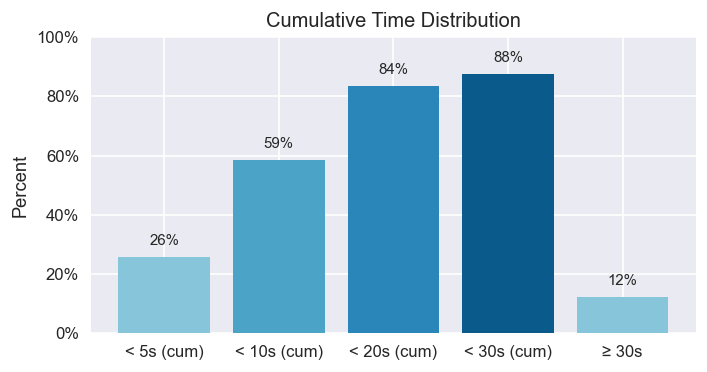

In [155]:
# -- Display Statisctics ---

import matplotlib.pyplot as plt

# Prices (mean, max, min, sum)
price_stats = pd.DataFrame({
    'Metric': ['Mean', 'Max', 'Min', 'Sum'],
    'Total Price ($)': [
        advanced_df['total_price'].mean(),
        advanced_df['total_price'].max(),
        advanced_df['total_price'].min(),
        advanced_df['total_price'].sum(),
    ],
})

def style_currency_table(df: pd.DataFrame):
    return (df.style
              .set_table_styles([
                  {'selector': 'th', 'props': [('background-color', '#f6f8fa'), ('text-align', 'left')]},
                  {'selector': 'td', 'props': [('padding', '6px 12px')]}
              ])
              .format({'Total Price ($)': '${:,.6f}'}))

# Display price stats
display(HTML('<h3>Advanced Summaries — Price Stats</h3>'))
display(style_currency_table(price_stats))

# Latency cumulative distribution
under_5 = (advanced_df['time_in_seconds'] < 5).mean()
under_10 = (advanced_df['time_in_seconds'] < 10).mean()
under_20 = (advanced_df['time_in_seconds'] < 20).mean()
under_30 = (advanced_df['time_in_seconds'] < 30).mean()
over_30 = (advanced_df['time_in_seconds'] >= 30).mean()

latency_dist_df = pd.DataFrame({
    'Bucket': ['< 5s (cum)', '< 10s (cum)', '< 20s (cum)', '< 30s (cum)', '≥ 30s'],
    'Percent': [under_5, under_10, under_20, under_30, over_30],
})

# Display latency header
display(HTML('<h3>Advanced Summaries — Latency (Cumulative)</h3>'))

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(6, 3.2), dpi=120)
bars = ax.bar(latency_dist_df['Bucket'], latency_dist_df['Percent'], color=['#86c5da', '#4ba3c7', '#2a86b9', '#0a5a8c'])
ax.set_ylim(0, 1)
ax.set_ylabel('Percent')
ax.set_title('Cumulative Time Distribution')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
for b, v in zip(bars, latency_dist_df['Percent']):
    ax.text(b.get_x() + b.get_width()/2, min(v + 0.03, 0.98), f'{v:.0%}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()



## 5) Evaluation

### a) Price and Latency
This comprehensive analysis provides **cost and performance insights** for different summarization approaches, enabling data-driven decisions for production deployment.

In [160]:
# Price and Latency Analysis
print("="*70)
print("💰 PRICE & ⚡ LATENCY EVALUATION")
print("="*70)

def analyze_price_latency(df, summary_type):
    """Analyze price and latency metrics for a summary type"""
    
    # Check which columns exist
    time_col = 'time_in_seconds'
    price_cols = ['input_price', 'output_price', 'total_price']
    
    # Filter out columns that exist
    available_cols = [col for col in [time_col] + price_cols if col in df.columns]
    
    if not available_cols:
        print(f"❌ No price/latency data found for {summary_type}")
        return None
    
    print(f"\n📊 {summary_type.upper()} SUMMARY ANALYSIS")
    print("-" * 50)
    
    # Latency Analysis
    if time_col in df.columns:
        mean_time = df[time_col].mean()
        total_time = df[time_col].sum()
        median_time = df[time_col].median()
        max_time = df[time_col].max()
        min_time = df[time_col].min()
        
        print(f"⚡ LATENCY METRICS:")
        print(f"  • Mean time per summary: {mean_time:.3f} seconds")
        print(f"  • Median time per summary: {median_time:.3f} seconds")
        print(f"  • Total processing time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        print(f"  • Fastest summary: {min_time:.3f} seconds")
        print(f"  • Slowest summary: {max_time:.3f} seconds")
        print(f"  • Processing rate: {len(df)/total_time:.2f} summaries/second")
    
    # Price Analysis
    price_analysis = {}
    if any(col in df.columns for col in price_cols):
        print(f"\n💰 COST METRICS:")
        
        for col in price_cols:
            if col in df.columns:
                mean_price = df[col].mean()
                total_price = df[col].sum()
                price_analysis[col] = {'mean': mean_price, 'total': total_price}
                
                print(f"  • Mean {col.replace('_', ' ')}: ${mean_price:.6f}")
                if col == 'total_price':
                    print(f"  • Total price for 1,000 summaries: ${total_price:.4f}")
                else:
                    print(f"  • Total {col.replace('_', ' ')}: ${total_price:.4f}")
        
        # Cost efficiency metrics
        if 'total_price' in df.columns and time_col in df.columns:
            cost_per_second = df['total_price'].sum() / df[time_col].sum()
            print(f"  • Cost efficiency: ${cost_per_second:.6f} per processing second")
    
    return {
        'summary_type': summary_type,
        'count': len(df),
        'time_metrics': {
            'mean': df[time_col].mean() if time_col in df.columns else None,
            'total': df[time_col].sum() if time_col in df.columns else None,
            'median': df[time_col].median() if time_col in df.columns else None,
        },
        'price_metrics': price_analysis
    }

# Analyze each summary type
lite_analysis = analyze_price_latency(lite_df, 'lite')
balanced_analysis = analyze_price_latency(balanced_df, 'balanced')
advanced_analysis = analyze_price_latency(advanced_df, 'advanced')

💰 PRICE & ⚡ LATENCY EVALUATION

📊 LITE SUMMARY ANALYSIS
--------------------------------------------------
⚡ LATENCY METRICS:
  • Mean time per summary: 0.083 seconds
  • Median time per summary: 0.015 seconds
  • Total processing time: 83.27 seconds (1.39 minutes)
  • Fastest summary: 0.000 seconds
  • Slowest summary: 10.936 seconds
  • Processing rate: 12.01 summaries/second

📊 BALANCED SUMMARY ANALYSIS
--------------------------------------------------
⚡ LATENCY METRICS:
  • Mean time per summary: 1.558 seconds
  • Median time per summary: 1.458 seconds
  • Total processing time: 1558.47 seconds (25.97 minutes)
  • Fastest summary: 0.889 seconds
  • Slowest summary: 13.192 seconds
  • Processing rate: 0.64 summaries/second

💰 COST METRICS:
  • Mean input price: $0.000011
  • Total input price: $0.0105
  • Mean output price: $0.000016
  • Total output price: $0.0161
  • Mean total price: $0.000027
  • Total price for 1,000 summaries: $0.0266
  • Cost efficiency: $0.000017 per proces

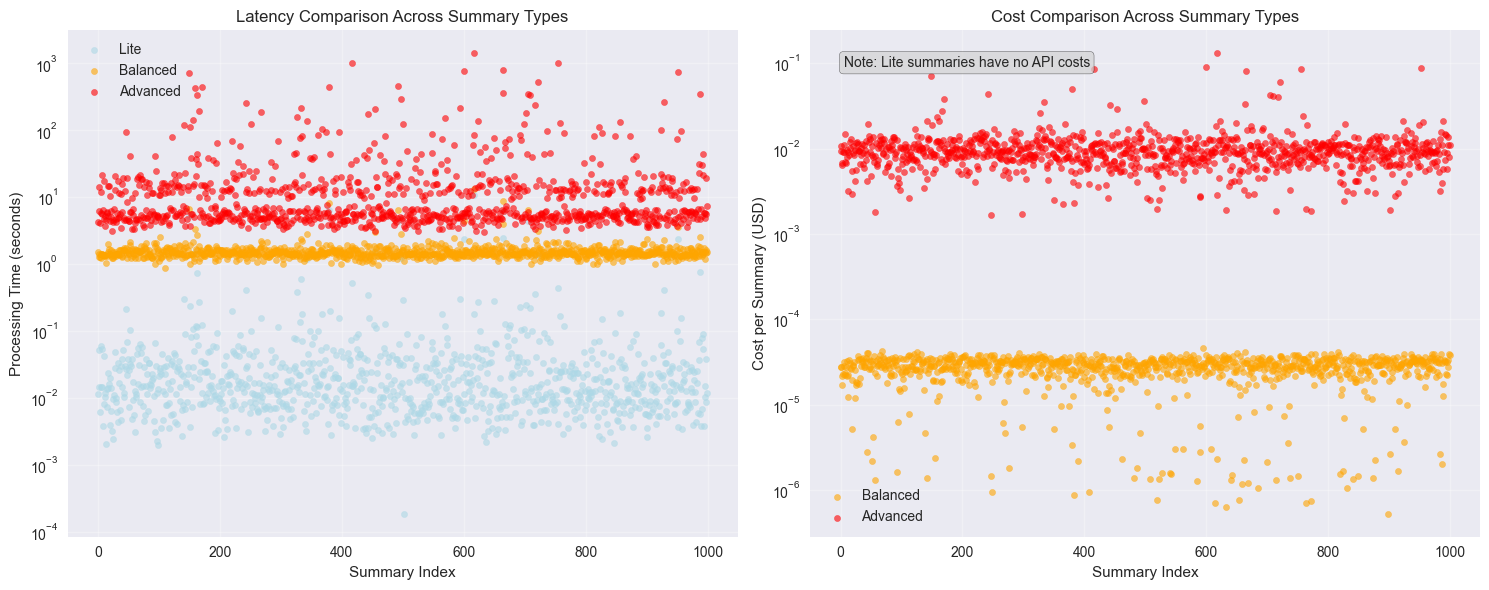

In [168]:
# --- Create scatter plots for latency and price comparison ---

import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Latency Scatter Plot

# Create sample indices for x-axis (just enumeration of summaries)
lite_x = np.arange(len(lite_df))
balanced_x = np.arange(len(balanced_df))
advanced_x = np.arange(len(advanced_df))

# Plot latency data
ax1.scatter(lite_x, lite_df['time_in_seconds'], alpha=0.6, s=20, color='lightblue', label='Lite')
ax1.scatter(balanced_x, balanced_df['time_in_seconds'], alpha=0.6, s=20, color='orange', label='Balanced')
ax1.scatter(advanced_x, advanced_df['time_in_seconds'], alpha=0.6, s=20, color='red', label='Advanced')

ax1.set_xlabel('Summary Index')
ax1.set_ylabel('Processing Time (seconds)')
ax1.set_title('Latency Comparison Across Summary Types')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Log scale due to wide range of values

# 2. Price Scatter Plot

# For price, we only have data for balanced and advanced summaries
# Balanced uses 'total_price', Advanced might use 'price' or 'total_price'
balanced_price = balanced_df['total_price'] if 'total_price' in balanced_df.columns else []

# Try to find the correct price column for advanced summaries
if 'price' in advanced_df.columns:
    advanced_price = advanced_df['price']
elif 'total_price' in advanced_df.columns:
    advanced_price = advanced_df['total_price'] 
else:
    advanced_price = []

# Plot balanced summaries
if len(balanced_price) > 0:
    ax2.scatter(balanced_x, balanced_price, alpha=0.6, s=20, color='orange', label='Balanced')

# Plot advanced summaries
if len(advanced_price) > 0:
    ax2.scatter(advanced_x, advanced_price, alpha=0.6, s=20, color='red', label='Advanced')

ax2.set_xlabel('Summary Index')
ax2.set_ylabel('Cost per Summary (USD)')
ax2.set_title('Cost Comparison Across Summary Types')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')  # Log scale due to wide range of values

# Add text annotation showing that Lite summaries have no cost
ax2.text(0.05, 0.95, 'Note: Lite summaries have no API costs', 
         transform=ax2.transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7),
         verticalalignment='top')

plt.tight_layout()
plt.show()

### b) G-EVal

Our implementation evaluates summaries across **four critical criteria**:

1. **Coherence (1-5 scale)**
   - Assesses the **logical flow** and structural organization
   - Evaluates whether the summary builds coherently from sentence to sentence
   - Focuses on **narrative structure** and information ordering
   - *"Is this a well-organized, logical summary?"*

2. **Consistency (1-5 scale)**
   - Measures **factual alignment** between summary and source document
   - Detects and penalizes **hallucinations** or incorrect information
   - Ensures all summary statements are **entailed by the source**
   - *"Does this summary contain only accurate information from the source?"*

3. **Fluency (1-3 scale)**
   - Evaluates **language quality**: grammar, spelling, punctuation
   - Assesses **readability** and natural language flow
   - Checks for **syntactic correctness** and word choice
   - *"Is this summary well-written and easy to read?"*

4. **Relevance (1-5 scale)**
   - Measures **content selection** and importance ranking
   - Evaluates coverage of **key information** from the source
   - Penalizes **redundancy** and irrelevant content inclusion
   - *"Does this summary capture the most important information?"*

Together, the 4 criteria balance linguistic quality with factual accuracy — areas where purely overlap-based metrics like ROUGE or BERTScore fall short — providing a multi-dimensional, human-aligned evaluation of summary usefulness and trustworthiness.

In [ ]:
# --- Create LLM ---

from langchain_aws import ChatBedrockConverse

client = boto3.client('bedrock-runtime', region_name='us-east-1')

# Use Sonnet 4
llm = ChatBedrockConverse(
    client=client,
    model_id="us.anthropic.claude-sonnet-4-20250514-v1:0"
)

In [201]:
# --- Get system prompts for G-Eval ---

with open('g_eval_prompts/coherence.txt', 'r') as file:
    coherence_system_prompt = file.read()

with open('g_eval_prompts/consistency.txt', 'r') as file:
    consistency_system_prompt = file.read()

with open('g_eval_prompts/fluency.txt', 'r') as file:
    fluency_system_prompt = file.read()

with open('g_eval_prompts/relevance.txt', 'r') as file:
    relevance_system_prompt = file.read()

# --- Create user prompts for G-Eval ---

user_prompt = """<source_document>
{input}
</source_document>

<summary>
{summary}
</summary>"""

fluency_user_prompt = """<summary>
{input}
</summary>"""

In [202]:
from pydantic import BaseModel
from langchain_core.prompts import ChatPromptTemplate
from tqdm import tqdm

# --- Define structured output schemas for each criteria ---

class CoherenceScore(BaseModel):
    coherence: str

class ConsistencyScore(BaseModel):
    consistency: str

class FluencyScore(BaseModel):
    fluency: str

class RelevanceScore(BaseModel):
    relevance: str

In [203]:
# --- Create structured LLMs for each criteria ---

coherence_llm = llm.with_structured_output(CoherenceScore)
consistency_llm = llm.with_structured_output(ConsistencyScore)
fluency_llm = llm.with_structured_output(FluencyScore)
relevance_llm = llm.with_structured_output(RelevanceScore)

# --- Create prompt templates for each criteria ---

coherence_prompt = ChatPromptTemplate.from_messages([
    ("system", coherence_system_prompt),
    ("human", user_prompt)
])

consistency_prompt = ChatPromptTemplate.from_messages([
    ("system", consistency_system_prompt),
    ("human", user_prompt)
])

fluency_prompt = ChatPromptTemplate.from_messages([
    ("system", fluency_system_prompt),
    ("human", fluency_user_prompt)
])

relevance_prompt = ChatPromptTemplate.from_messages([
    ("system", relevance_system_prompt),
    ("human", user_prompt)
])

# --- Create evaluation chains ---

coherence_chain = coherence_prompt | coherence_llm
consistency_chain = consistency_prompt | consistency_llm
fluency_chain = fluency_prompt | fluency_llm
relevance_chain = relevance_prompt | relevance_llm

In [204]:
# --- LexRank Summarizer ---

# LexRank is used to summarize the text
# Texts might be too long for the LLM to handle, so we use LexRank to summarize the text
# Creating summaries of 7000 characters (~2000 words)

from graph_rank_summarizer import LexRankConfig, LexRankSummarizer
from preprocess import clean_web_text

cfg = LexRankConfig(analyzer="word", ngram_range=(3,5), threshold=0.1, max_chars=7000)
smr = LexRankSummarizer(cfg)

In [237]:
import os
import time

def evaluate_summaries_batch(df, summary_column, batch_size=5):
    """
    Evaluate summaries using G-Eval with batch processing for speed.

    Args:
        df: DataFrame containing summaries to evaluate
        summary_column: Column name containing the summaries
        batch_size: Number of summaries to process in each batch

    Returns:
        DataFrame with added score columns
    """

    # Prepare data for evaluation
    summaries = df[summary_column].tolist()
    source_docs = df['markdown_content'].tolist()

    # Prepare inputs for batch processing
    coherence_inputs = []
    consistency_inputs = []
    fluency_inputs = []
    relevance_inputs = []

    for summary, source_doc in zip(summaries, source_docs):
        source_doc = clean_web_text(source_doc)
        lex_smr = smr.summarize(title=None, text=source_doc)['summary']
        # Coherence, consistency, relevance need both source doc and summary
        coherence_inputs.append({"input": lex_smr, "summary": summary})
        consistency_inputs.append({"input": lex_smr, "summary": summary})
        relevance_inputs.append({"input": lex_smr, "summary": summary})

        # Fluency only needs the summary
        fluency_inputs.append({"input": summary})

    print(f"Evaluating {len(summaries)} summaries...")

    # Process in batches using LangChain's batch function
    coherence_scores = []
    consistency_scores = []
    fluency_scores = []
    relevance_scores = []

    # Process coherence
    print("Evaluating coherence...")

    # If the coherence scores file exists, skip the coherence evaluation
    if os.path.exists(f'evaluation/{summary_column.split("_")[0]}/coherence_scores.json'):
        # Load the coherence scores from the file
        with open(f'evaluation/{summary_column.split("_")[0]}/coherence_scores.json', 'r') as f:
            coherence_scores = json.load(f)
        print("Coherence scores file exists, skipping coherence evaluation")
    else:
        for i in tqdm(range(0, len(coherence_inputs), batch_size)):
            batch = coherence_inputs[i:i+batch_size]
            batch_results = coherence_chain.batch(batch)
            coherence_scores.extend([result.coherence for result in batch_results])
            # Wait 10 seconds before the next batch
            time.sleep(10)
        # Save the coherence scores to a file
        with open(f'evaluation/{summary_column.split("_")[0]}/coherence_scores.json', 'w') as f:
            json.dump(coherence_scores, f)

    # Process consistency
    print("Evaluating consistency...")

    # If the consistency scores file exists, skip the consistency evaluation
    if os.path.exists(f'evaluation/{summary_column.split("_")[0]}/consistency_scores.json'):
        # Load the consistency scores from the file
        with open(f'evaluation/{summary_column.split("_")[0]}/consistency_scores.json', 'r') as f:
            consistency_scores = json.load(f)
        print("Consistency scores file exists, skipping consistency evaluation")
    else:
        for i in tqdm(range(0, len(consistency_inputs), batch_size)):
            batch = consistency_inputs[i:i+batch_size]
            batch_results = consistency_chain.batch(batch)
            consistency_scores.extend([result.consistency for result in batch_results])
        # Save the consistency scores to a file
        with open(f'evaluation/{summary_column.split("_")[0]}/consistency_scores.json', 'w') as f:
            json.dump(consistency_scores, f)

    # Process fluency
    print("Evaluating fluency...")

    # If the fluency scores file exists, skip the fluency evaluation
    if os.path.exists(f'evaluation/{summary_column.split("_")[0]}/fluency_scores.json'):
        # Load the fluency scores from the file
        with open(f'evaluation/{summary_column.split("_")[0]}/fluency_scores.json', 'r') as f:
            fluency_scores = json.load(f)
        print("Fluency scores file exists, skipping fluency evaluation")
    else:
        for i in tqdm(range(0, len(fluency_inputs), batch_size)):
            batch = fluency_inputs[i:i+batch_size]
            batch_results = fluency_chain.batch(batch)
            fluency_scores.extend([result.fluency for result in batch_results])
        # Save the fluency scores to a file
        with open(f'evaluation/{summary_column.split("_")[0]}/fluency_scores.json', 'w') as f:
            json.dump(fluency_scores, f)

    # Process relevance
    print("Evaluating relevance...")

    # If the relevance scores file exists, skip the relevance evaluation
    if os.path.exists(f'evaluation/{summary_column.split("_")[0]}/relevance_scores.json'):
        # Load the relevance scores from the file
        with open(f'evaluation/{summary_column.split("_")[0]}/relevance_scores.json', 'r') as f:
            relevance_scores = json.load(f)
        print("Relevance scores file exists, skipping relevance evaluation")
    else:
        for i in tqdm(range(0, len(relevance_inputs), batch_size)):
            batch = relevance_inputs[i:i+batch_size]
            batch_results = relevance_chain.batch(batch)
            relevance_scores.extend([result.relevance for result in batch_results])
        # Save the relevance scores to a file
        with open(f'evaluation/{summary_column.split("_")[0]}/relevance_scores.json', 'w') as f:
            json.dump(relevance_scores, f)

    # Add scores to dataframe
    df_copy = df.copy()
    df_copy[f'{summary_column}_coherence'] = coherence_scores
    df_copy[f'{summary_column}_consistency'] = consistency_scores
    df_copy[f'{summary_column}_fluency'] = fluency_scores
    df_copy[f'{summary_column}_relevance'] = relevance_scores

    print("Evaluation completed!")
    return df_copy

In [222]:
# --- Run G-Eval on lite summaries ---

print("="*50)
print("EVALUATING LITE SUMMARIES")
print("="*50)

lite_df_evaluated = evaluate_summaries_batch(lite_df, summary_column='lite_summary', batch_size=10)

EVALUATING LITE SUMMARIES
Evaluating 1000 summaries...
Evaluating coherence...


100%|██████████| 100/100 [08:30<00:00,  5.10s/it]


Evaluating consistency...


100%|██████████| 100/100 [09:21<00:00,  5.62s/it]


Evaluating fluency...


100%|██████████| 100/100 [05:45<00:00,  3.46s/it]


Evaluating relevance...


100%|██████████| 100/100 [08:48<00:00,  5.29s/it]

Evaluation completed!


In [ ]:
# Save the lite summaries after G-Eval
lite_df_evaluated.to_pickle("summaries/lite_summaries.pkl")

In [239]:
# --- Run G-Eval on balanced summaries ---

print("="*50)
print("EVALUATING BALANCED SUMMARIES")
print("="*50)
balanced_df_evaluated = evaluate_summaries_batch(balanced_df, summary_column='balanced_summary', batch_size=15)

EVALUATING BALANCED SUMMARIES
Evaluating 1000 summaries...
Evaluating coherence...
Coherence scores file exists, skipping coherence evaluation
Evaluating consistency...
Consistency scores file exists, skipping consistency evaluation
Evaluating fluency...
Fluency scores file exists, skipping fluency evaluation
Evaluating relevance...
Relevance scores file exists, skipping relevance evaluation
Evaluation completed!


In [241]:
# Save the balanced summaries after G-Eval
balanced_df_evaluated.to_pickle("summaries/balanced_summaries.pkl")

In [245]:
# --- Run G-Eval on advanced summaries ---
print("="*50)
print("EVALUATING ADVANCED SUMMARIES")
print("="*50)
advanced_df_evaluated = evaluate_summaries_batch(advanced_df, summary_column='advanced_summary', batch_size=15)

EVALUATING ADVANCED SUMMARIES
Evaluating 1000 summaries...
Evaluating coherence...
Coherence scores file exists, skipping coherence evaluation
Evaluating consistency...


100%|██████████| 67/67 [07:41<00:00,  6.88s/it]


Evaluating fluency...


100%|██████████| 67/67 [05:06<00:00,  4.58s/it]


Evaluating relevance...


100%|██████████| 67/67 [08:24<00:00,  7.53s/it]

Evaluation completed!


In [268]:
# Save the advanced summaries after G-Eval
advanced_df_evaluated.to_pickle("summaries/advanced_summaries.pkl")

In [271]:
# --- Display results and analysis ---

print("="*50)
print("EVALUATION RESULTS SUMMARY")
print("="*50)

def convert_scores_to_numeric(df, summary_type):
    """Convert string scores to numeric for analysis"""
    score_columns = [f'{summary_type}_coherence', f'{summary_type}_consistency', 
                    f'{summary_type}_fluency', f'{summary_type}_relevance']
    
    for col in score_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

# Convert scores to numeric
lite_df_evaluated = convert_scores_to_numeric(lite_df_evaluated, 'lite_summary')
balanced_df_evaluated = convert_scores_to_numeric(balanced_df_evaluated, 'balanced_summary')
advanced_df_evaluated = convert_scores_to_numeric(advanced_df_evaluated, 'advanced_summary')

# Display average scores
print("\nLITE SUMMARIES - Average Scores:")
lite_scores = lite_df_evaluated[['lite_summary_coherence', 'lite_summary_consistency', 
                                'lite_summary_fluency', 'lite_summary_relevance']].mean()
print(lite_scores)

print("\nBALANCED SUMMARIES - Average Scores:")
balanced_scores = balanced_df_evaluated[['balanced_summary_coherence', 'balanced_summary_consistency', 
                                        'balanced_summary_fluency', 'balanced_summary_relevance']].mean()
print(balanced_scores)

print("\nADVANCED SUMMARIES - Average Scores:")
advanced_scores = advanced_df_evaluated[['advanced_summary_coherence', 'advanced_summary_consistency', 
                                        'advanced_summary_fluency', 'advanced_summary_relevance']].mean()
print(advanced_scores)


EVALUATION RESULTS SUMMARY

LITE SUMMARIES - Average Scores:
lite_summary_coherence      1.940
lite_summary_consistency    4.706
lite_summary_fluency        1.662
lite_summary_relevance      2.265
dtype: float64

BALANCED SUMMARIES - Average Scores:
balanced_summary_coherence      3.785
balanced_summary_consistency    4.371
balanced_summary_fluency        2.924
balanced_summary_relevance      4.004
dtype: float64

ADVANCED SUMMARIES - Average Scores:
advanced_summary_coherence      2.693
advanced_summary_consistency    2.449
advanced_summary_fluency        2.933
advanced_summary_relevance      2.600
dtype: float64


In [277]:
i = 20
display(HTML(balanced_df_evaluated.loc[i, 'balanced_summary']))
display(HTML(advanced_df_evaluated.loc[i, 'advanced_summary']))

### **G-Eval Results Interpretation**

The G-Eval results reveal **counterintuitive patterns** that challenge our initial expectations about summarization quality:

**Balanced Summaries Perform Best Overall:**
- **Coherence**: 3.785 (highest) - Best logical flow and organization
- **Relevance**: 4.004 (highest) - Superior content selection and importance ranking
- **Fluency**: 2.924 (highest) - Best language quality and readability

**Lite Summaries Excel at Factual Consistency:**
- **Consistency**: 4.706 (highest) - Extractive approach preserves source accuracy
- However, poor coherence (1.940) and fluency (1.662) due to sentence-level extraction

**Advanced Summaries Underperform Expectations:**
- **Consistency**: 2.449 (lowest) - Recursive compression might introduce cumulative errors
- All metrics lower than Balanced despite higher computational complexity

---

*Why Advanced Summaries Score Lower*?

1. **Recursive Summarization Problems**: Multiple LLM passes (Nova Lite → concatenation → Nova Lite → Claude Sonnet 4) might introduce:
   - **Cumulative hallucinations** at each compression step
   - **Information drift** from original source content
   - **Context loss** during aggressive compression

2. **Over-Engineering Effect**: The sophisticated multi-stage pipeline suffers from:
   - **Too many transformation steps** increasing error propagation
   - **Token budget constraints** forcing overly aggressive compression
   - **Disconnect from source material** after multiple abstractions

3. **Evaluation Against Source Documents**: G-Eval compares summaries to original content, where:
   - **Balanced summaries** maintain closer fidelity to source while improving fluency
   - **Advanced summaries** become too abstracted from original content

---

**Balanced Approach Emerges as Optimal:**
- **Best quality-cost-speed trade-off** for production deployment
- **Single-pass generative rewriting** hits the "sweet spot" of summarization
- **Simpler pipeline** with fewer failure modes

**Key Lesson**: More sophisticated ≠ better performance. Sometimes **simpler, well-designed approaches** outperform complex multi-stage systems.

---

### c) Additional Metrics

While G-Eval provides sophisticated **LLM-based assessment**, traditional **automated metrics** remain essential for comprehensive evaluation. These metrics offer **quantitative**, **reproducible**, and **computationally efficient** measures that complement human-like judgment with objective statistical analysis.

We calculate the following metrics using the provided Baseline Summaries as reference summaries:

#### ROUGE Metrics

ROUGE metrics measure **lexical overlap** between candidate and reference summaries, providing insights into content coverage and textual similarity.

1. **ROUGE-1**
   - Measures **unigram overlap** (individual word matches)
   - Captures **vocabulary coverage** and basic content alignment
   - *Best for*: Overall content similarity assessment

2. **ROUGE-2** 
   - Measures **bigram overlap** (two-word phrase matches)
   - Captures **phrase-level similarity** and word ordering
   - *Best for*: Semantic structure evaluation

3. **ROUGE-L**
   - Measures **Longest Common Subsequence** (LCS)
   - Captures **structural similarity** and sentence-level organization
   - *Best for*: Summary flow and organization assessment

#### BERTScore

BERTScore leverages **pre-trained transformer models** to capture **semantic similarity** beyond surface-level word matching.

In [ ]:
import nltk
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import numpy as np
from tqdm import tqdm

# Download required NLTK data
nltk.download('punkt', quiet=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [315]:
def compute_rouge_scores(references, candidates):
    """
    Compute ROUGE-1, ROUGE-2, and ROUGE-L scores for summaries.
    
    Args:
        references: List of reference summaries 
        candidates: List of candidate summaries to evaluate
        
    Returns:
        Dictionary with ROUGE scores
    """
    
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    rouge1_f = []
    rouge1_p = []
    rouge1_r = []
    rouge2_f = []
    rouge2_p = []
    rouge2_r = []
    rougeL_f = []
    rougeL_p = []
    rougeL_r = []
    
    print("Computing ROUGE scores...")
    for ref, cand in tqdm(zip(references, candidates), total=len(references)):
        # Handle NaN or empty summaries
        if pd.isna(ref) or pd.isna(cand) or ref == "" or cand == "":
            rouge1_f.append(0.0)
            rouge1_p.append(0.0)
            rouge1_r.append(0.0)
            rouge2_f.append(0.0)
            rouge2_p.append(0.0)
            rouge2_r.append(0.0)
            rougeL_f.append(0.0)
            rougeL_p.append(0.0)
            rougeL_r.append(0.0)
            continue
            
        scores = scorer.score(str(ref), str(cand))
        
        rouge1_f.append(scores['rouge1'].fmeasure)
        rouge1_p.append(scores['rouge1'].precision)
        rouge1_r.append(scores['rouge1'].recall)
        
        rouge2_f.append(scores['rouge2'].fmeasure)
        rouge2_p.append(scores['rouge2'].precision)
        rouge2_r.append(scores['rouge2'].recall)
        
        rougeL_f.append(scores['rougeL'].fmeasure)
        rougeL_p.append(scores['rougeL'].precision)
        rougeL_r.append(scores['rougeL'].recall)
    
    return {
        'rouge1_f': rouge1_f,
        'rouge1_p': rouge1_p,
        'rouge1_r': rouge1_r,
        'rouge2_f': rouge2_f,
        'rouge2_p': rouge2_p,
        'rouge2_r': rouge2_r,
        'rougeL_f': rougeL_f,
        'rougeL_p': rougeL_p,
        'rougeL_r': rougeL_r
    }

def compute_bertscore(references, candidates):
    """
    Compute BERTScore for summaries.
    
    Args:
        references: List of reference summaries
        candidates: List of candidate summaries to evaluate
        
    Returns:
        Dictionary with BERTScore precision, recall, and F1
    """
    
    print("Computing BERTScore...")
    
    # Handle NaN or empty summaries
    valid_refs = []
    valid_cands = []
    valid_indices = []
    
    for i, (ref, cand) in enumerate(zip(references, candidates)):
        if not pd.isna(ref) and not pd.isna(cand) and ref != "" and cand != "":
            valid_refs.append(str(ref))
            valid_cands.append(str(cand))
            valid_indices.append(i)
    
    if len(valid_refs) == 0:
        return {
            'bert_precision': [0.0] * len(references),
            'bert_recall': [0.0] * len(references), 
            'bert_f1': [0.0] * len(references)
        }
    
    # Compute BERTScore for valid summaries
    P, R, F1 = bert_score(valid_cands, 
                        valid_refs, 
                        model_type="distilbert-base-uncased", # Smaller model for faster computation
                        lang="en", 
                        verbose=False)
    
    # Create full arrays with zeros for invalid summaries
    full_precision = [0.0] * len(references)
    full_recall = [0.0] * len(references)
    full_f1 = [0.0] * len(references)
    
    # Fill in valid scores
    for i, idx in enumerate(valid_indices):
        full_precision[idx] = P[i].item()
        full_recall[idx] = R[i].item()
        full_f1[idx] = F1[i].item()
    
    return {
        'bert_precision': full_precision,
        'bert_recall': full_recall,
        'bert_f1': full_f1
    }

In [316]:
def evaluate_additional_metrics(df, summary_column):
    """
    Evaluate summaries using ROUGE and BERTScore metrics against baseline summaries.
    
    Args:
        df: DataFrame containing summaries to evaluate
        summary_column: Column name containing the candidate summaries
        
    Returns:
        DataFrame with added metric columns
    """
    # Get reference column name - now using baseline summaries
    reference_column = 'baseline_summary'

    candidates = df[summary_column].tolist()
    references = df[reference_column].tolist()  # Use baseline summaries as reference
    
    print(f"Evaluating {len(candidates)} summaries with additional metrics...")
    print(f"Candidate column: {summary_column}")
    print(f"Reference column: {reference_column}")
    
    # Compute ROUGE scores
    rouge_scores = compute_rouge_scores(references, candidates)
    
    # Compute BERTScore
    bert_scores = compute_bertscore(references, candidates)
    
    # Add scores to dataframe
    df_copy = df.copy()
    
    # Add ROUGE scores
    df_copy[f'{summary_column}_rouge1_f'] = rouge_scores['rouge1_f']
    df_copy[f'{summary_column}_rouge1_p'] = rouge_scores['rouge1_p']
    df_copy[f'{summary_column}_rouge1_r'] = rouge_scores['rouge1_r']
    
    df_copy[f'{summary_column}_rouge2_f'] = rouge_scores['rouge2_f']
    df_copy[f'{summary_column}_rouge2_p'] = rouge_scores['rouge2_p']
    df_copy[f'{summary_column}_rouge2_r'] = rouge_scores['rouge2_r']
    
    df_copy[f'{summary_column}_rougeL_f'] = rouge_scores['rougeL_f']
    df_copy[f'{summary_column}_rougeL_p'] = rouge_scores['rougeL_p']
    df_copy[f'{summary_column}_rougeL_r'] = rouge_scores['rougeL_r']
    
    # Add BERTScore
    df_copy[f'{summary_column}_bert_precision'] = bert_scores['bert_precision']
    df_copy[f'{summary_column}_bert_recall'] = bert_scores['bert_recall']
    df_copy[f'{summary_column}_bert_f1'] = bert_scores['bert_f1']
    
    print("Additional metrics evaluation completed!")
    return df_copy

In [317]:
# --- Apply additional metrics to all summary types ---

print("="*60)
print("EVALUATING ADDITIONAL METRICS (ROUGE & BERTScore)")
print("All evaluations against BASELINE SUMMARIES as reference")
print("="*60)

# Evaluate lite summaries against baseline summaries
print("\n" + "="*50)
print("LITE SUMMARIES vs BASELINE SUMMARIES")
print("="*50)
lite_df_with_metrics = evaluate_additional_metrics(lite_df, 'lite_summary')

# Evaluate balanced summaries against baseline summaries   
print("\n" + "="*50)
print("BALANCED SUMMARIES vs BASELINE SUMMARIES")
print("="*50)
balanced_df_with_metrics = evaluate_additional_metrics(balanced_df, 'balanced_summary')

# Evaluate advanced summaries against baseline summaries
print("\n" + "="*50)
print("ADVANCED SUMMARIES vs BASELINE SUMMARIES")
print("="*50)
advanced_df_with_metrics = evaluate_additional_metrics(advanced_df, 'advanced_summary')

EVALUATING ADDITIONAL METRICS (ROUGE & BERTScore)
All evaluations against BASELINE SUMMARIES as reference

LITE SUMMARIES vs BASELINE SUMMARIES
Evaluating 1000 summaries with additional metrics...
Candidate column: lite_summary
Reference column: baseline_summary
Computing ROUGE scores...


100%|██████████| 1000/1000 [00:25<00:00, 39.66it/s]


Computing BERTScore...
Additional metrics evaluation completed!

BALANCED SUMMARIES vs BASELINE SUMMARIES
Evaluating 1000 summaries with additional metrics...
Candidate column: balanced_summary
Reference column: baseline_summary
Computing ROUGE scores...


100%|██████████| 1000/1000 [00:13<00:00, 73.35it/s]


Computing BERTScore...
Additional metrics evaluation completed!

ADVANCED SUMMARIES vs BASELINE SUMMARIES
Evaluating 1000 summaries with additional metrics...
Candidate column: advanced_summary
Reference column: baseline_summary
Computing ROUGE scores...


100%|██████████| 1000/1000 [00:14<00:00, 70.03it/s]


Computing BERTScore...
Additional metrics evaluation completed!


In [318]:
# --- Display additional metrics results ---

print("="*60)
print("ADDITIONAL METRICS RESULTS SUMMARY")
print("(All evaluated against baseline summaries)")
print("="*60)

def display_additional_metrics_summary(df, summary_type):
    """Display summary statistics for additional metrics"""
    
    rouge_cols = [f'{summary_type}_rouge1_f', f'{summary_type}_rouge2_f', f'{summary_type}_rougeL_f']
    bert_cols = [f'{summary_type}_bert_precision', f'{summary_type}_bert_recall', f'{summary_type}_bert_f1']
    
    print(f"\n{summary_type.upper()} SUMMARIES:")
    print("-" * 40)
    
    # ROUGE scores
    print("ROUGE Scores (F-measure):")
    for col in rouge_cols:
        if col in df.columns:
            avg_score = df[col].mean()
            print(f"  {col.split('_')[-2].upper()}-{col.split('_')[-1].upper()}: {avg_score:.4f}")
    
    # BERTScore
    print("\nBERTScore:")
    for col in bert_cols:
        if col in df.columns:
            avg_score = df[col].mean()
            metric_name = col.split('_')[-1].capitalize()
            print(f"  {metric_name}: {avg_score:.4f}")

# Display results for all three summary types
display_additional_metrics_summary(lite_df_with_metrics, 'lite_summary')
display_additional_metrics_summary(balanced_df_with_metrics, 'balanced_summary')
display_additional_metrics_summary(advanced_df_with_metrics, 'advanced_summary')

ADDITIONAL METRICS RESULTS SUMMARY
(All evaluated against baseline summaries)

LITE_SUMMARY SUMMARIES:
----------------------------------------
ROUGE Scores (F-measure):
  ROUGE1-F: 0.3860
  ROUGE2-F: 0.2185
  ROUGEL-F: 0.2818

BERTScore:
  Precision: 0.7735
  Recall: 0.8095
  F1: 0.7902

BALANCED_SUMMARY SUMMARIES:
----------------------------------------
ROUGE Scores (F-measure):
  ROUGE1-F: 0.3054
  ROUGE2-F: 0.0947
  ROUGEL-F: 0.1833

BERTScore:
  Precision: 0.7651
  Recall: 0.7531
  F1: 0.7583

ADVANCED_SUMMARY SUMMARIES:
----------------------------------------
ROUGE Scores (F-measure):
  ROUGE1-F: 0.2982
  ROUGE2-F: 0.0924
  ROUGEL-F: 0.1762

BERTScore:
  Precision: 0.7594
  Recall: 0.7552
  F1: 0.7566


### **Results Interpretation**

The ROUGE and BERTScore evaluation against baseline summaries reveals a **reversal** of the G-Eval findings, highlighting fundamental differences between reference-based and quality-based evaluation paradigms.

#### **Performance Ranking: Lite > Balanced > Advanced**

**Lite Summaries (Best Performance)**
- **ROUGE-1 F1**: 0.3860 - Strong word-level overlap with baseline summaries
- **ROUGE-2 F1**: 0.2185 - Good preservation of phrase-level content  
- **BERTScore F1**: 0.7902 - Higher semantic similarity to reference summaries

**Balanced Summaries (Moderate Performance)**
- **ROUGE-1 F1**: 0.3054 - Moderate lexical overlap due to generative rewriting
- **ROUGE-2 F1**: 0.0947 - Lower phrase preservation from LLM abstraction
- **BERTScore F1**: 0.7583 - Good semantic alignment despite different phrasing

**Advanced Summaries (Lowest Performance)**
- **ROUGE-1 F1**: 0.2982 - Limited overlap due to aggressive compression
- **ROUGE-2 F1**: 0.0924 - Minimal phrase-level similarity 
- **BERTScore F1**: 0.7566 - Decent semantic alignment

#### **Why This Contradicts G-Eval Results**

The **fundamental disagreement** between evaluation approaches stems from what each measures:

| Evaluation Type | What It Measures | Winner |
|-----------------|------------------|---------|
| **ROUGE/BERTScore vs Baseline** | Content fidelity & preservation | **Lite** |
| **G-Eval vs Source Documents** | Human-perceived quality | **Balanced** |

In addition, there's a vast difference between the reference in G-Eval (LexRank summarized document) and that in ROUGE/BERTScore (provided baseline summary).

#### **Extractive vs. Generative Trade-offs**

**Lite (Extractive) Advantages:**
- **High fidelity**: Direct sentence extraction preserves original wording
- **Content coverage**: BERTScore recall of 0.8095 shows excellent baseline coverage
- **Lexical preservation**: Maintains vocabulary and phrasing from source material

**Balanced/Advanced (Generative) Disadvantages in Reference-Based Metrics:**
- **Paraphrasing penalty**: LLM rewriting reduces exact word matches
- **Style divergence**: Fluent generation may deviate from baseline summary style
- **Abstraction cost**: Higher-level summarization moves away from surface-level similarity

#### **The Evaluation Paradox**

These conflicting results illustrate a **core challenge in summarization evaluation**:

1. **Reference-based metrics** (ROUGE/BERTScore) favor approaches that closely mirror existing summaries
2. **Quality-based metrics** (G-Eval) favor approaches that produce coherent, fluent, and relevant content
3. **The "best" approach depends entirely on evaluation criteria and use case**

#### **Key Insight: Complexity ≠ Quality**

Both evaluation paradigms agree that the **Advanced approach underperforms**, validating the principle that sophisticated multi-stage pipelines can suffer from:
- **Error accumulation** across processing stages
- **Information drift** from recursive compression
- **Over-engineering** that optimizes for complexity rather than outcomes

The **Balanced approach emerges as the optimal choice for most production scenarios**, offering the best trade-off between human-perceived quality (G-Eval winner) and reasonable performance against reference standards.